In [8]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)


(9786, 15)

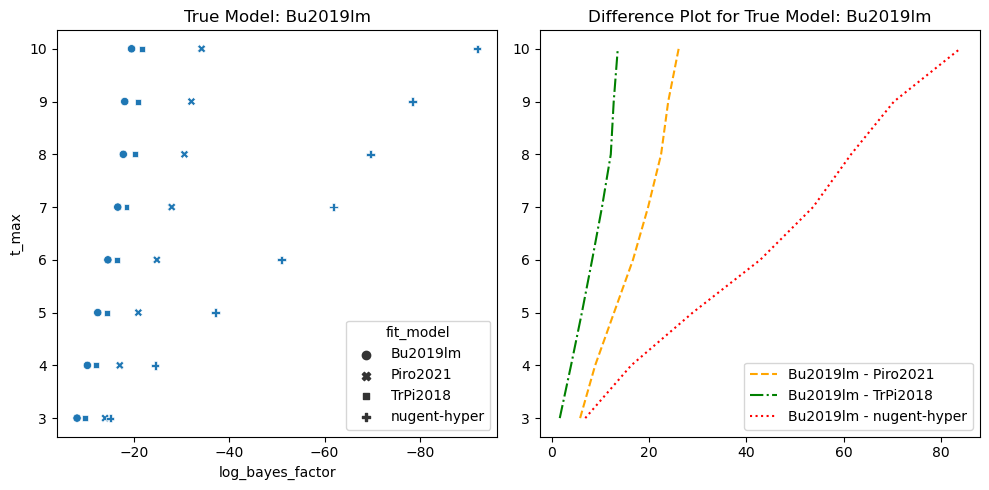

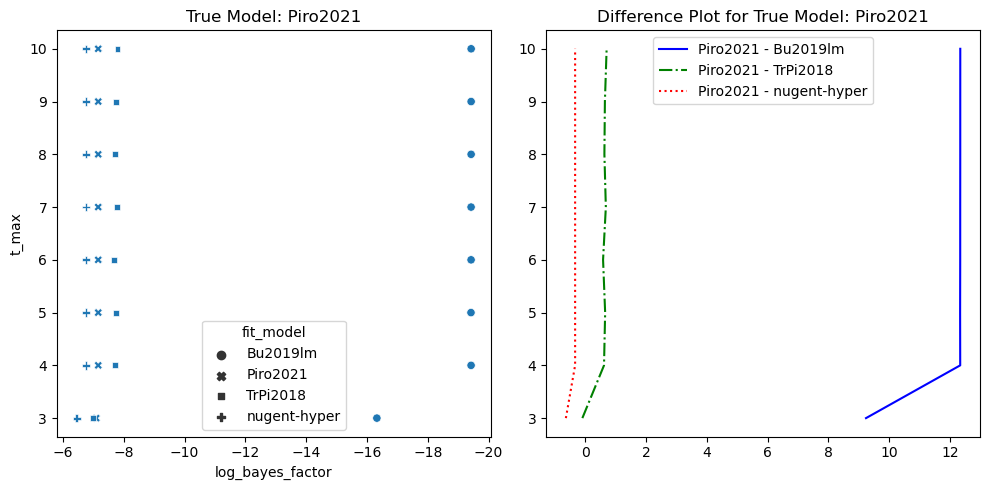

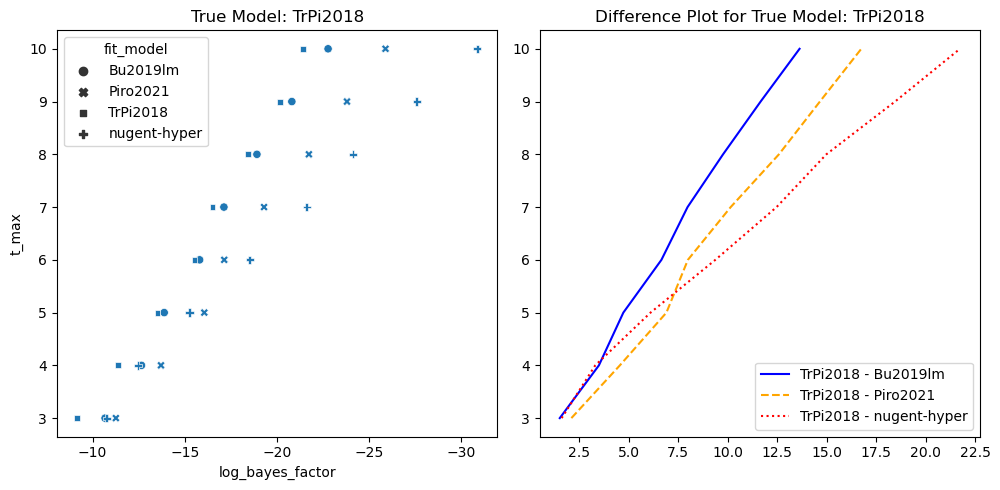

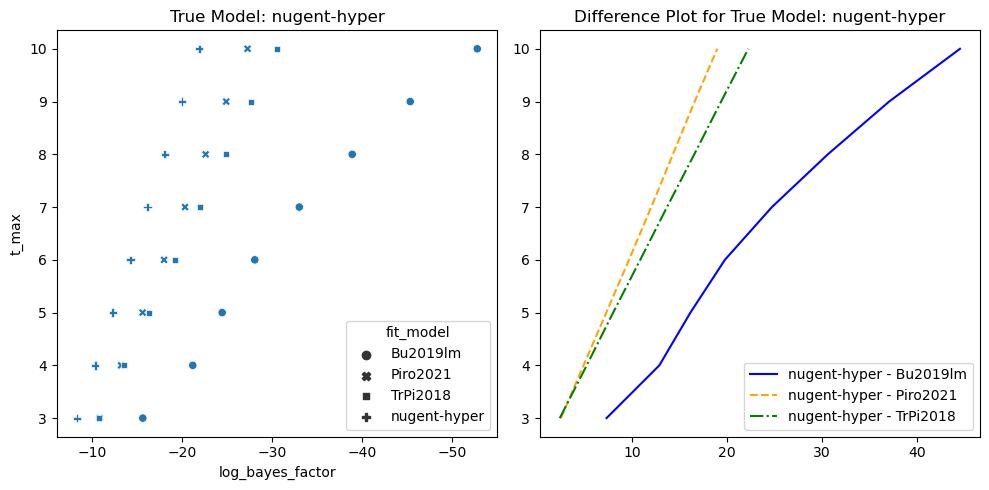

In [60]:
df = pd.read_csv('./model-recovery-timestep-incomplete-fit_df.csv')
display(df.shape)

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'median'}).reset_index()
# display(grouped_df)
## dictionary of linestyles for each model (models are found in fit_model column)
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

for model in grouped_df['true_model'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    ax0 = axs[0]
    iter_df = grouped_df[grouped_df['true_model'] == model]
    

    # # Calculate the mean and standard deviation of log_bayes_factor for each 't_max'
    # mean_log_bf = iter_df.groupby('t_max')['log_bayes_factor'].mean()
    # std_log_bf = iter_df.groupby('t_max')['log_bayes_factor'].std()
    
    # # Add error bars to the scatterplot for matching fit_model
    # for t_max in match_data['t_max'].unique():
    #     mean = mean_log_bf[t_max]
    #     std = std_log_bf[t_max]
    #     interval = std * 0.5  # One sigma

    #     data_for_t_max = match_data[match_data['t_max'] == t_max]
    #     ax0.errorbar(data_for_t_max['log_bayes_factor'], [t_max] * len(data_for_t_max),
    #                  xerr=interval, linestyle='None', color='black', capsize=3, capthick=1, alpha=0.5)

    sns.scatterplot(data=iter_df, x='log_bayes_factor', y='t_max',
                    style='fit_model', ax=ax0)
    


    ax0.set_title(f'True Model: {model}')
    ax0.invert_xaxis()

    ax1 = axs[1]
    for fit_model in grouped_df['true_model'].unique():
        if fit_model != model:
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax1.plot(diff, diff_df['t_max'], label=f'{model} - {fit_model}', linestyle=ls_dict[fit_model], color=color_dict[fit_model])

    ax1.set_title(f'Difference Plot for True Model: {model}')

    ax1.legend()

    plt.tight_layout()
    plt.show()

In [61]:
lowest_bayes = []
for lightcurve in  df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().min()].squeeze()
        lowest_bayes.append(lowest_bf_row )

lbf_df = pd.DataFrame(lowest_bayes)     
# display(lbf_df)

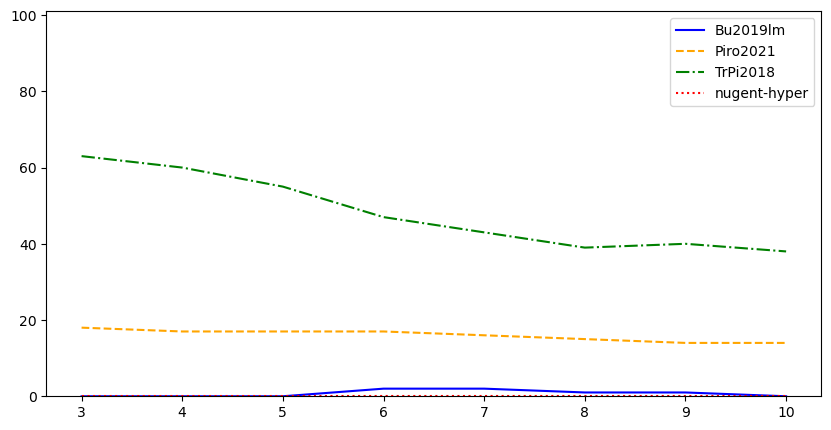


For t_max: 3.0
For true model: Bu2019lm, the percentage of incorrect identifications is: 0.0
For true model: Piro2021, the percentage of incorrect identifications is: 94.7
For true model: TrPi2018, the percentage of incorrect identifications is: 64.9
For true model: nugent-hyper, the percentage of incorrect identifications is: 0.0

For t_max: 4.0
For true model: Bu2019lm, the percentage of incorrect identifications is: 0.0
For true model: Piro2021, the percentage of incorrect identifications is: 89.5
For true model: TrPi2018, the percentage of incorrect identifications is: 61.9
For true model: nugent-hyper, the percentage of incorrect identifications is: 0.0

For t_max: 5.0
For true model: Bu2019lm, the percentage of incorrect identifications is: 0.0
For true model: Piro2021, the percentage of incorrect identifications is: 89.5
For true model: TrPi2018, the percentage of incorrect identifications is: 56.7
For true model: nugent-hyper, the percentage of incorrect identifications is: 0.

In [52]:
## plot the number of incorrect idenfications per model, grouped by t_max (x-axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for model in lbf_df['true_model'].unique():
    model_df = lbf_df[(lbf_df['true_model'] == model)]
    ## count number of incorrect identifications per t_max per model
    incorrect_identifications = []
    for tmax in sorted(model_df['t_max'].unique()):
        tmax_df = model_df[model_df['t_max'] == tmax]
        incorrect_identifications.append(len(tmax_df[tmax_df['fit_model'] != model]))
    ax.plot(sorted(model_df['t_max'].unique()), incorrect_identifications, label=model, linestyle=ls_dict[model], color=color_dict[model])
    ax.legend()
    ax.set_ylim(0, 101)
plt.show()


## from lbf_df, find percentage per model of incorrect identifications, grouped by t_max. there are 100 lightcurves for each model

for tmax in sorted(lbf_df['t_max'].unique()):
    print(f'\nFor t_max: {tmax}')
    for model in lbf_df['true_model'].unique():
        model_df = lbf_df[(lbf_df['true_model'] == model) & (lbf_df['t_max'] == tmax)]
        print(f'For true model: {model}, the percentage of incorrect identifications is: {round(len(model_df[model_df["fit_model"] != model]) / len(model_df)*100,1)}')
        


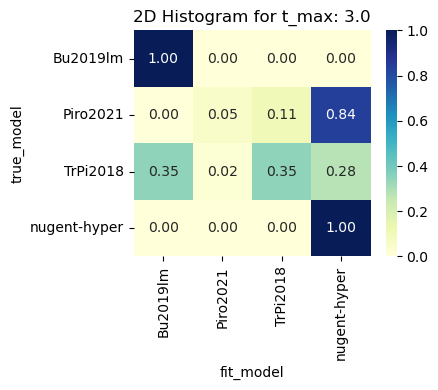

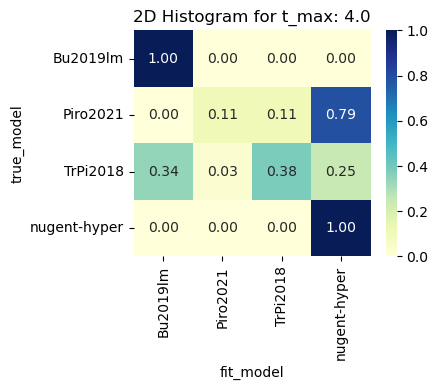

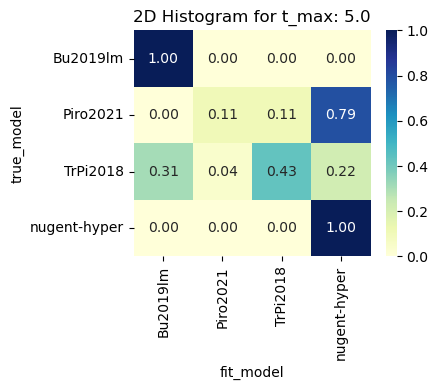

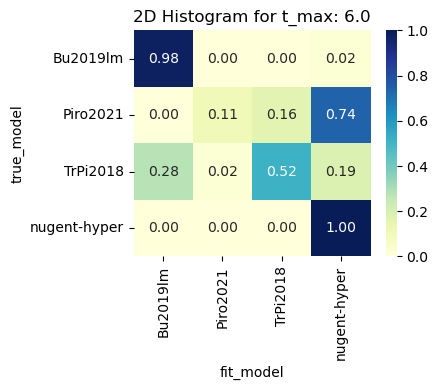

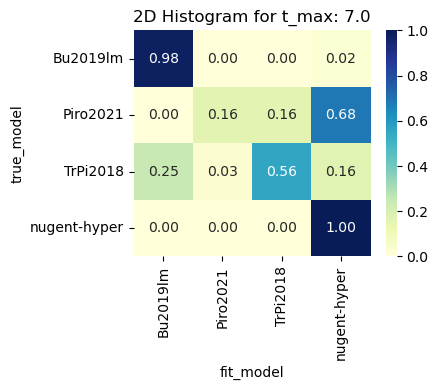

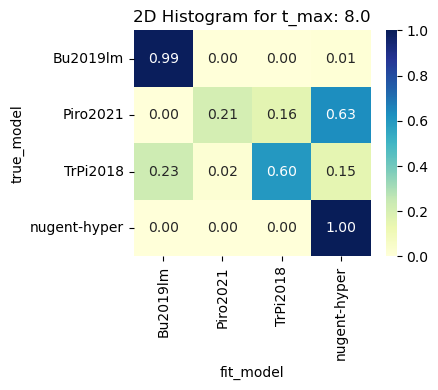

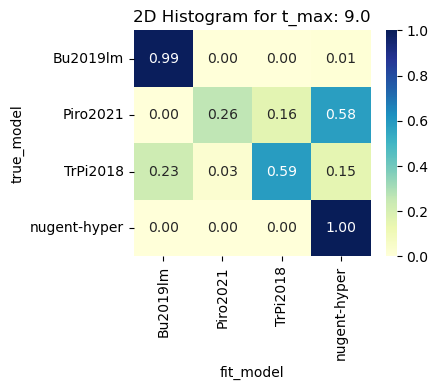

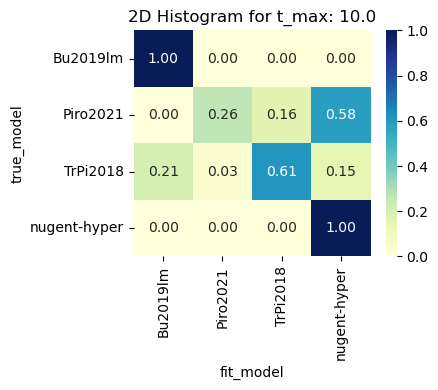

In [46]:
## for each lbf_df timestep, plot a 2d histogram of the true_mdodel vs fit_model
for tmax in sorted(lbf_df['t_max'].unique()):
    tmax_df = lbf_df[lbf_df['t_max'] == tmax]
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    ax.set_title(f'2D Histogram for t_max: {tmax}')
    fig.tight_layout()
    plt.show()

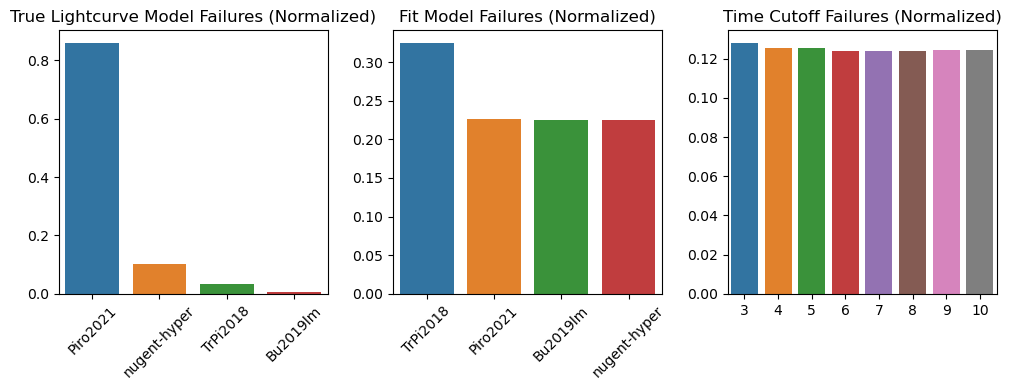

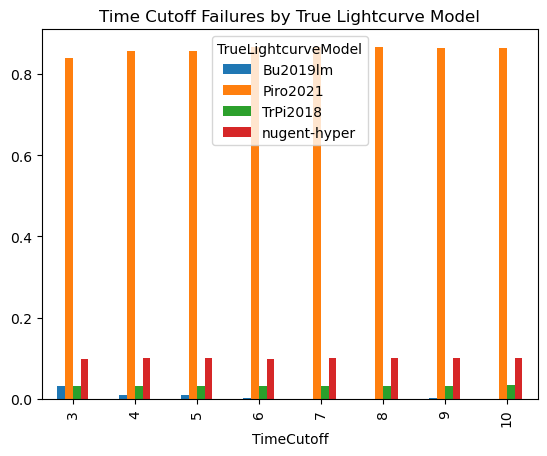

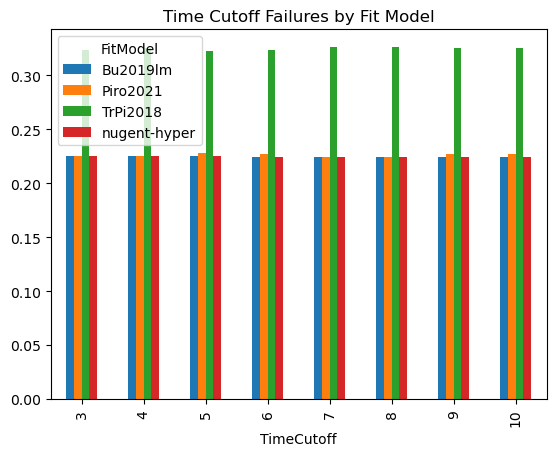

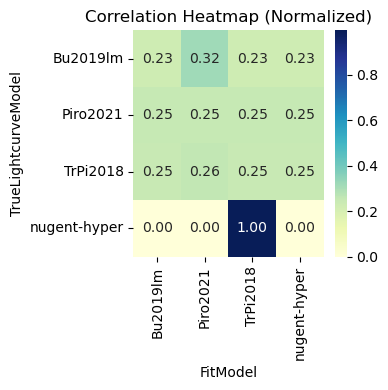

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "model-recovery-failures.txt"  
with open(file_path, 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    parts = line.strip().split('/')
    filename = parts[-1]
    model_parts = filename.split('_')
    true_lightcurve_model = model_parts[1]
    unique_identifier = model_parts[2]
    fit_model = model_parts[4]
    time_cutoff = int(model_parts[-1].split('_tmax_')[-1].split('.')[0])
    data.append([true_lightcurve_model, unique_identifier, fit_model, time_cutoff])

df = pd.DataFrame(data, columns=['TrueLightcurveModel', 'UniqueIdentifier', 'FitModel', 'TimeCutoff'])

total_entries = len(df)
true_lightcurve_failures = df['TrueLightcurveModel'].value_counts(normalize=True)
fit_model_failures = df['FitModel'].value_counts(normalize=True)
time_cutoff_failures = df['TimeCutoff'].value_counts(normalize=True)

# Create a heatmap to explore correlations between true lightcurve models and fit models
heatmap_data = df.groupby(['TrueLightcurveModel', 'FitModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
plt.figure(figsize=(10, 4))

plt.subplot(131)
sns.barplot(x=true_lightcurve_failures.index, y=true_lightcurve_failures.values)
plt.title('True Lightcurve Model Failures (Normalized)')
plt.xticks(rotation=45)

plt.subplot(132)
sns.barplot(x=fit_model_failures.index, y=fit_model_failures.values)
plt.title('Fit Model Failures (Normalized)')
plt.xticks(rotation=45)

plt.subplot(133)
sns.barplot(x=time_cutoff_failures.index, y=time_cutoff_failures.values)
plt.title('Time Cutoff Failures (Normalized)')
plt.tight_layout()
plt.show()

# # Plot based on the third value as True Lightcurve Model
# plt.subplot(121)
time_cutoff_by_true_lightcurve = df.groupby(['TimeCutoff', 'TrueLightcurveModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
time_cutoff_by_true_lightcurve.plot(kind='bar', stacked=False)
plt.title('Time Cutoff Failures by True Lightcurve Model')
plt.show()

# Plot based on the third value as Fit Model
# plt.subplot(122)
time_cutoff_by_fit_model = df.groupby(['TimeCutoff', 'FitModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
time_cutoff_by_fit_model.plot(kind='bar', stacked=False)
plt.title('Time Cutoff Failures by Fit Model')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(141)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Correlation Heatmap (Normalized)')

plt.tight_layout()
plt.show()


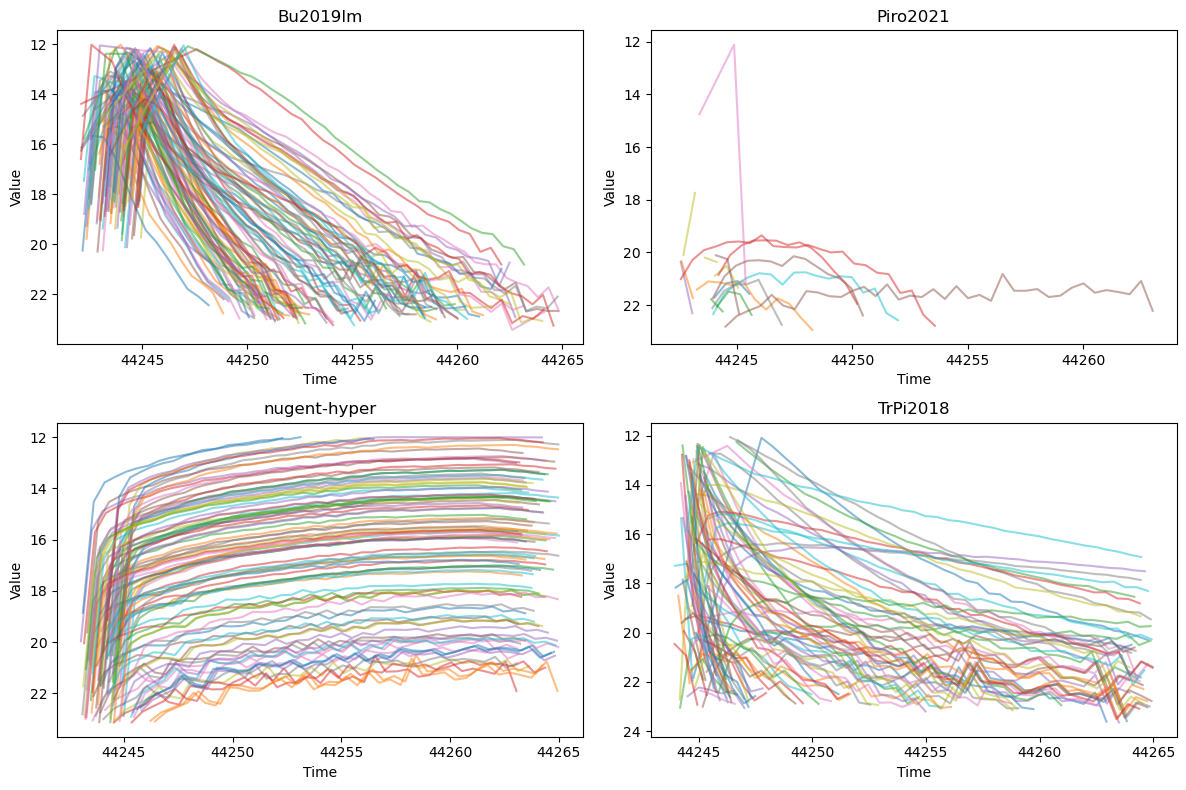

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'model-recovery-injections'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].append(ztfg_data)

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    [sns.lineplot(data=pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]), x="Time", y="Value", alpha=0.5) 
     for lc_data in lc_list]
    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [18]:
## read in txt file defined by file_path
import numpy as np
file_path = "model-recovery-failures.txt"
lc_names = []
with open(file_path, 'r') as file:
    lines = file.readlines()
for line in lines:
    lc_name = line.split('/')[7]

    lc_names.append(lc_name)

orig_size = np.shape(lc_names)
print('count w/ dupes: ',orig_size)
## remove duplicates from lc_names
lc_names = list(set(lc_names))
new_size = np.shape(lc_names)
print ('count w/o dupes: ',new_size)
print('% removed: ',(orig_size[0]-new_size[0])/orig_size[0])

count w/ dupes:  (3014,)
count w/o dupes:  (129,)
% removed:  0.9571997345719974


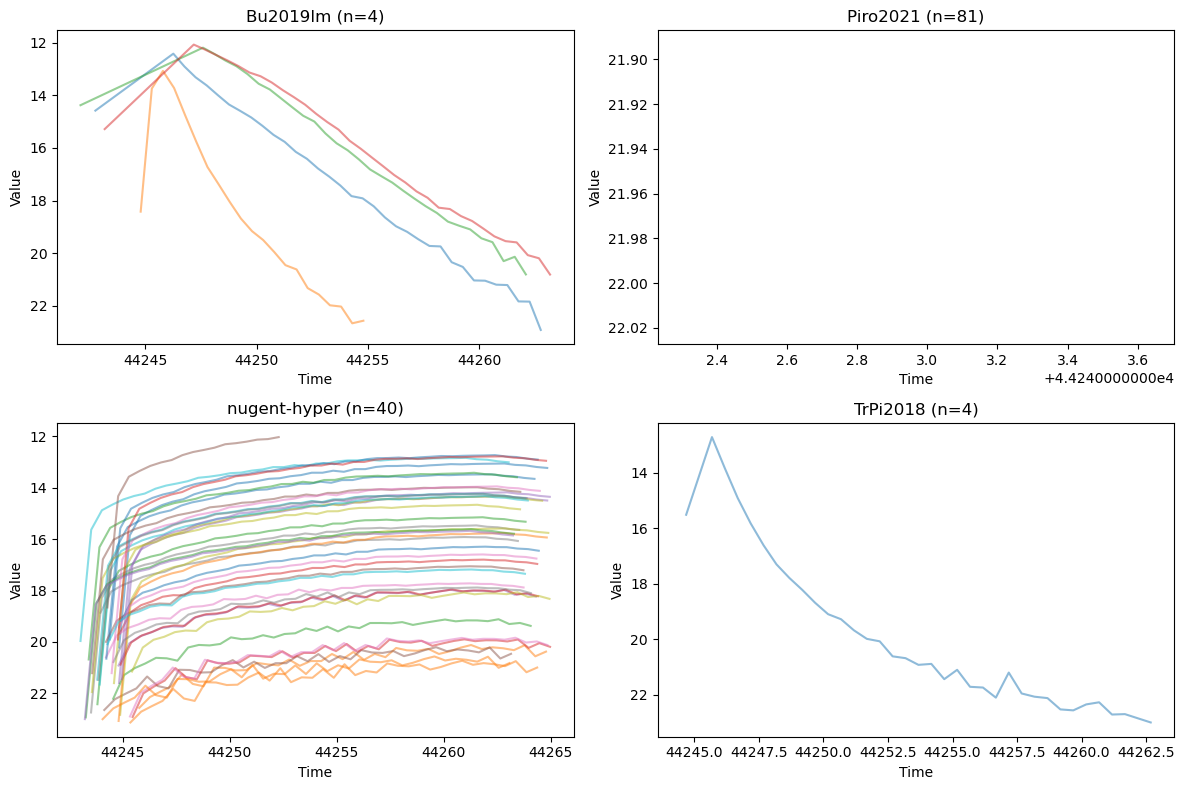

In [24]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'model-recovery-injections'
model_data = {}
model_data_count = {}
for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        ## check if filename is in lc_names (account for filename ending with json)
        if filename.split('.')[0] not in lc_names:
            continue
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
            model_data_count[model_name] = 0
        model_data[model_name].append(ztfg_data)
        model_data_count[model_name] += 1

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    [sns.lineplot(data=pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]), x="Time", y="Value", alpha=0.5) 
     for lc_data in lc_list]
    plt.title(f"{model_name} (n={model_data_count[model_name]})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()


plt.tight_layout()
plt.show()

Difference between Piro2021 injections when enforcing valid lightcurve generation

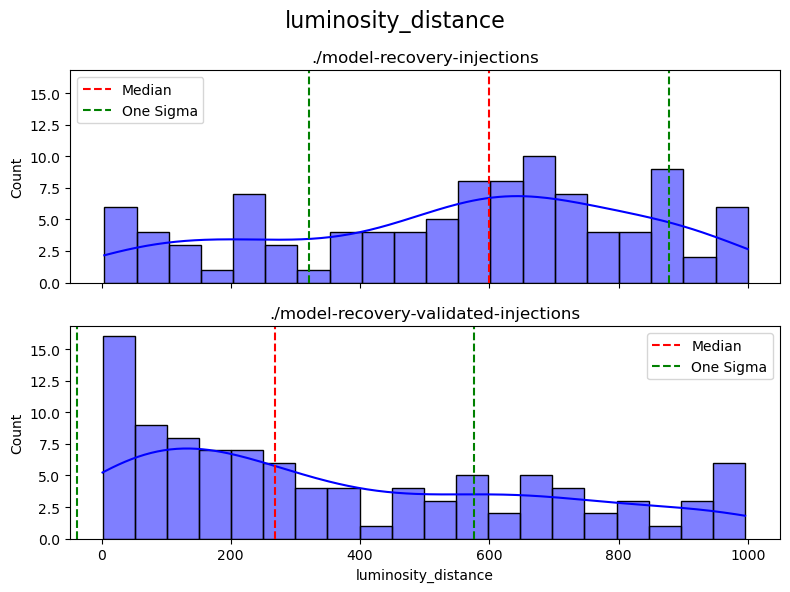

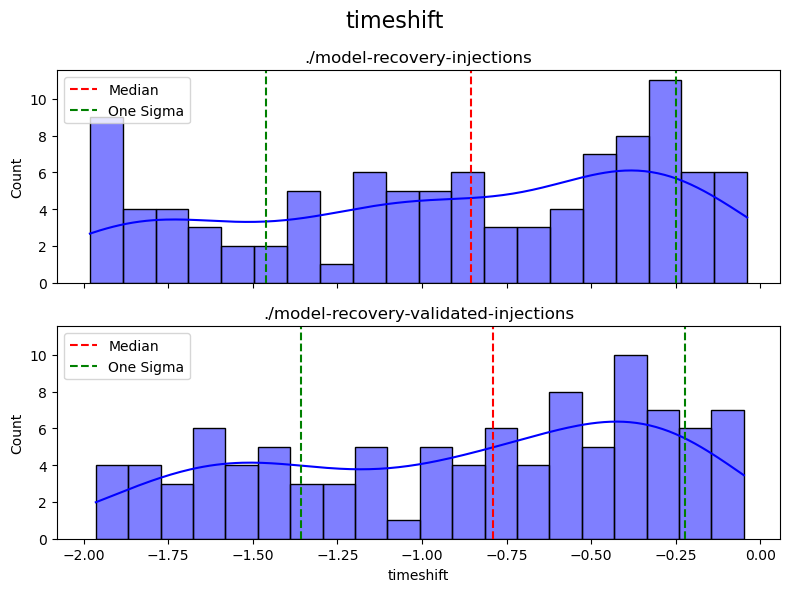

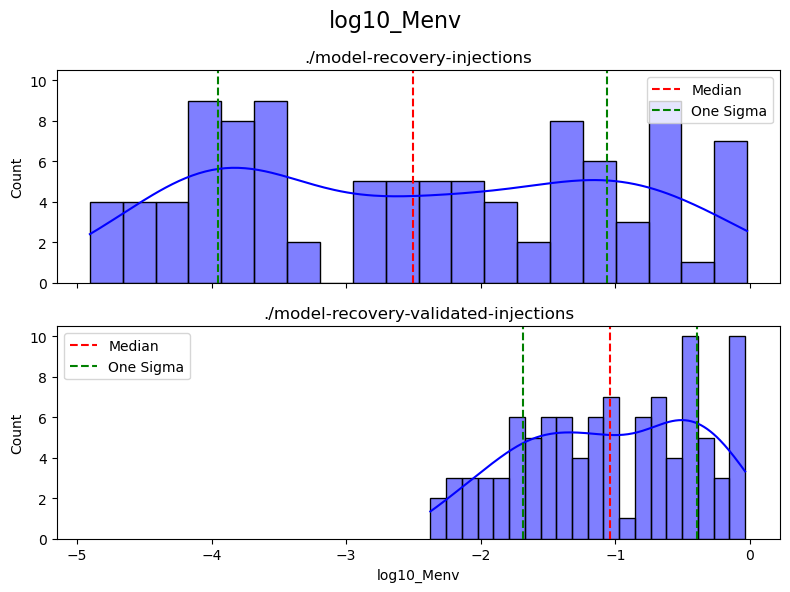

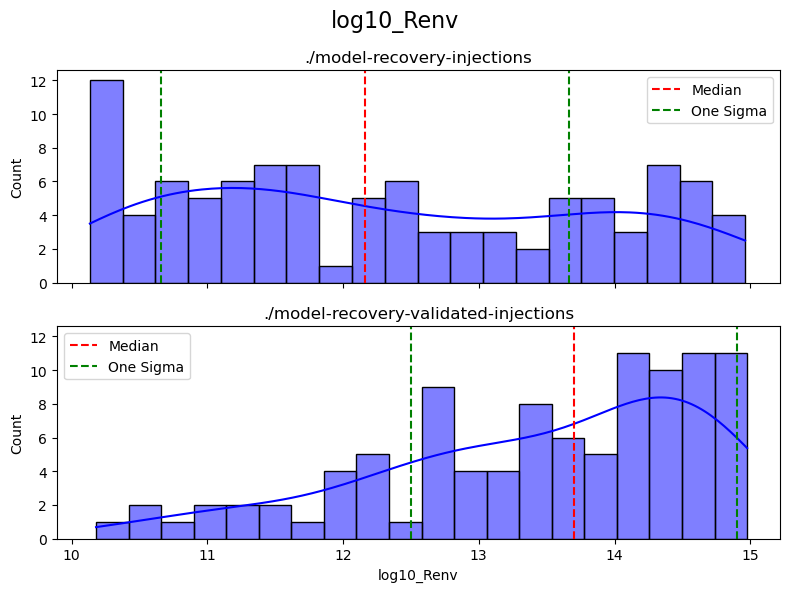

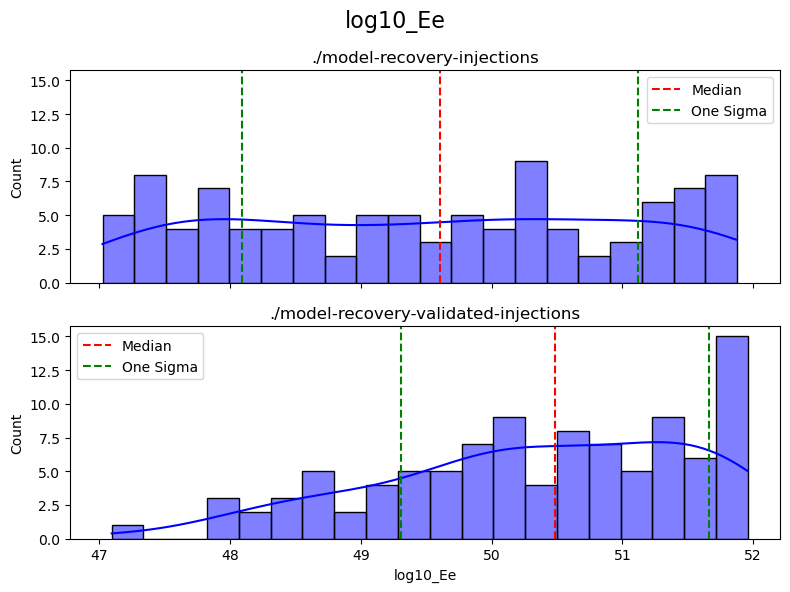

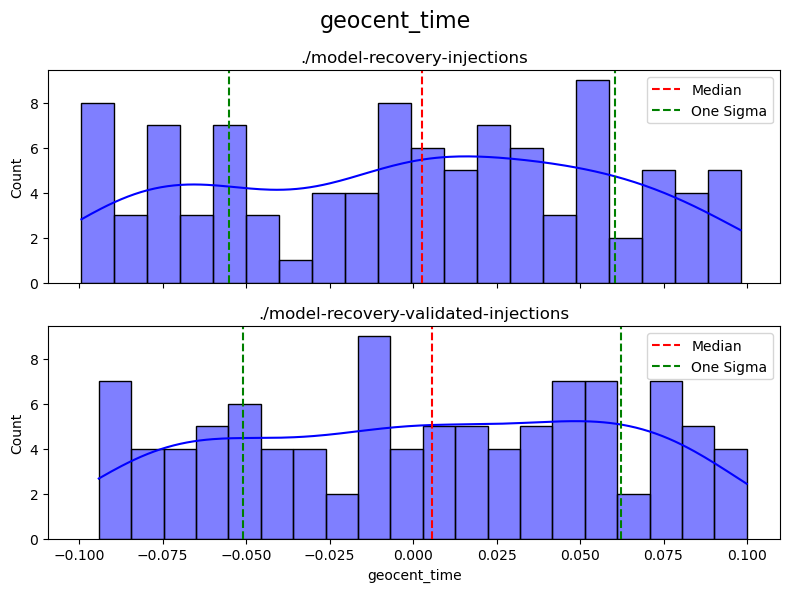

In [55]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./model-recovery-injections', './model-recovery-validated-injections']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma')
        ax.axvline(median + std, color='green', linestyle='--')
        
        # mu, std = norm.fit(df[column])
        
        # xmin, xmax = ax.get_xlim()
        # x = np.linspace(xmin, xmax, 100)
        # p = norm.pdf(x, mu, std)
        
        # ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    plt.tight_layout()

plt.show()


# for i, df in enumerate(dfs):
#     print(folder_paths[i])
#     display(df.describe())

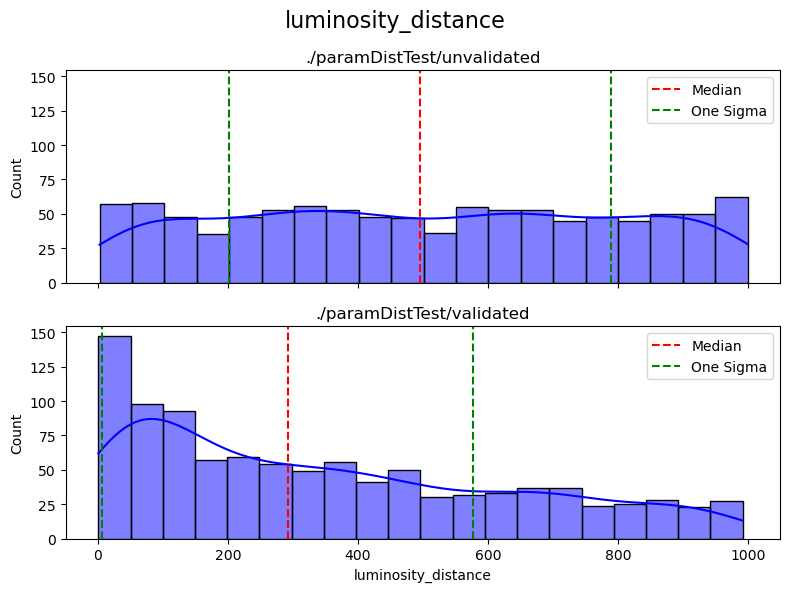

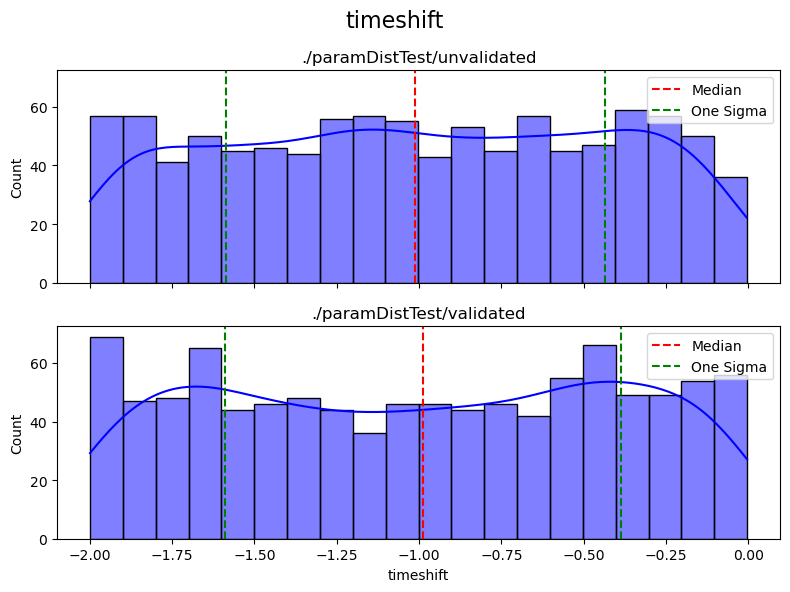

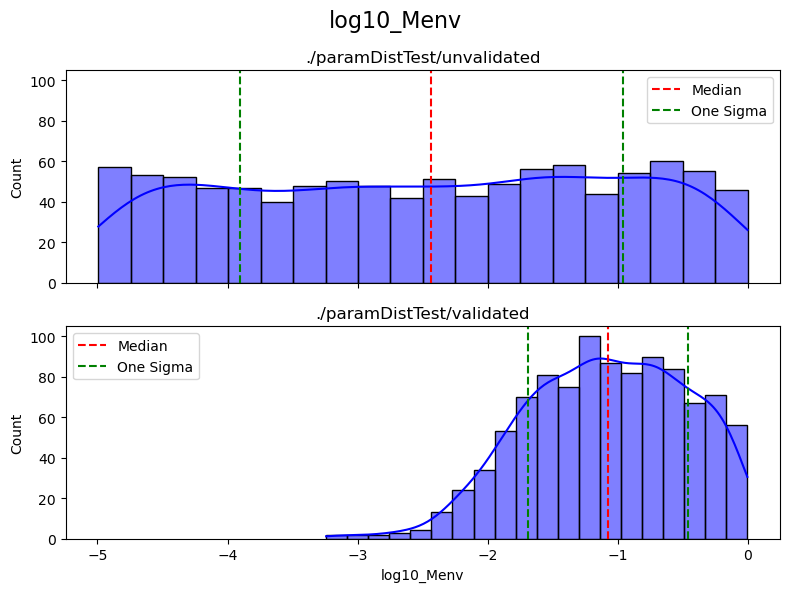

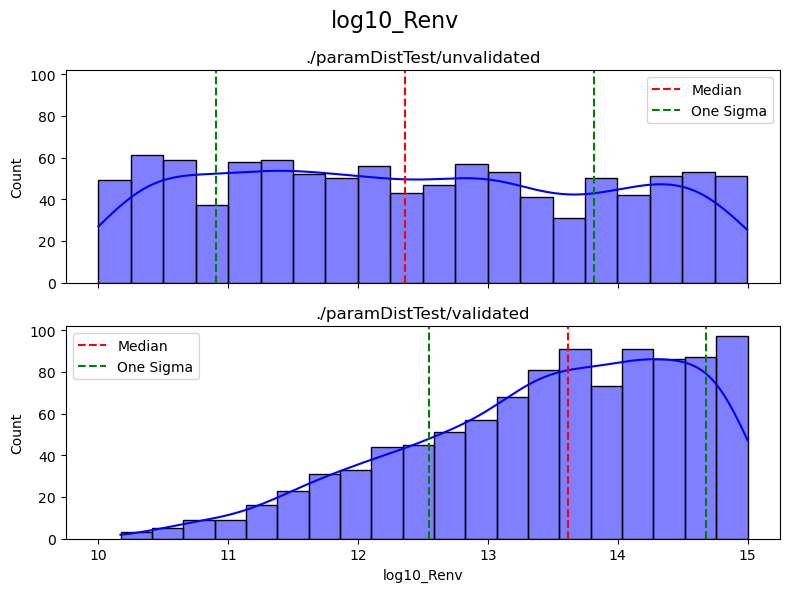

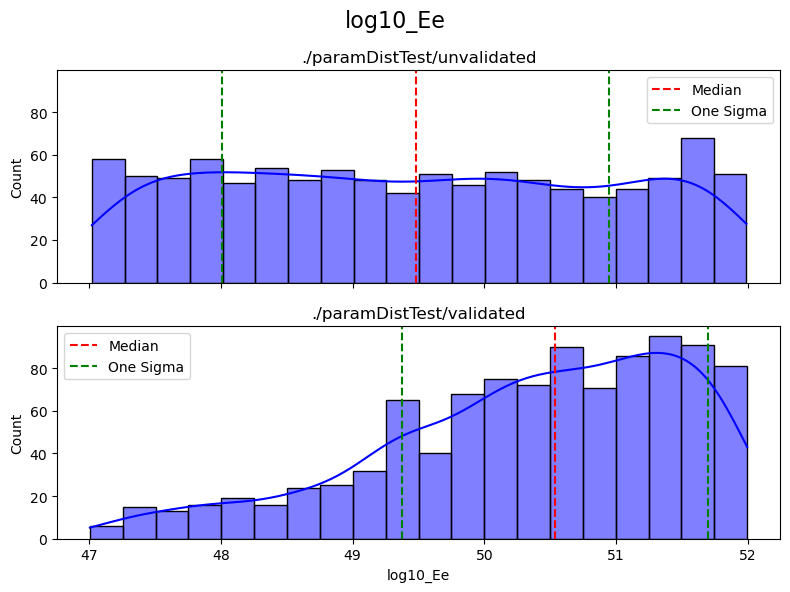

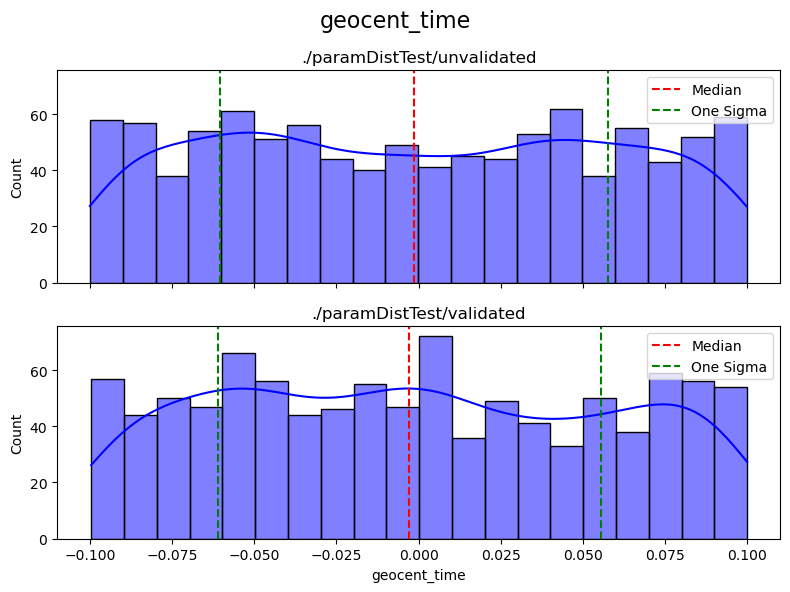

In [56]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./paramDistTest/unvalidated', './paramDistTest/validated']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma')
        ax.axvline(median + std, color='green', linestyle='--')
        
        # mu, std = norm.fit(df[column])
        
        # xmin, xmax = ax.get_xlim()
        # x = np.linspace(xmin, xmax, 100)
        # p = norm.pdf(x, mu, std)
        
        # ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    plt.tight_layout()

plt.show()


# for i, df in enumerate(dfs):
#     print(folder_paths[i])
#     display(df.describe())

In [29]:
import os
import json
import pandas as pd

# Define a function to extract the relevant information from the file name
def extract_info(file_name):
    parts = file_name.split('_')
    lightcurve = '_'.join(parts[1:3])
    true_model = parts[1]
    fit_model = parts[4]
    tmax = parts[-2]
    return lightcurve, true_model, fit_model, tmax

# Create a list to store data from JSON files
data = []

# Define the root directory where your JSON files are located
root_directory = './fits_expanse/'

# Traverse the directory and its subdirectories
for root, dirs, files in os.walk(root_directory):
    for file_name in files:
        if file_name.endswith('result.json'):
            file_path = os.path.join(root, file_name)
            try:
                with open(file_path, 'r') as json_file:
                    data_dict = json.load(json_file)
                    lightcurve, true_model, fit_model, tmax = extract_info(file_name)
                    log_bayes_factor = data_dict.get('log_bayes_factor', None)
                    sampling_time = data_dict.get('sampling_time', None)
                    data.append([lightcurve, true_model, fit_model, tmax, log_bayes_factor, sampling_time])
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['lightcurve', 'true_model', 'fit_model', 'tmax', 'log_bayes_factor', 'sampling_time'])
df['sampling_time_minutes'] = df['sampling_time'] / 60
display(df)


,lightcurve,true_model,fit_model,tmax,log_bayes_factor,sampling_time,sampling_time_minutes
0,nugent-hyper_00005,nugent-hyper,Me2017,17,-53.686710,751.567636,12.526127
1,nugent-hyper_00005,nugent-hyper,Me2017,07,-20.127784,195.237659,3.253961
2,nugent-hyper_00005,nugent-hyper,Me2017,13,-38.436035,433.369626,7.222827
3,nugent-hyper_00005,nugent-hyper,Me2017,11,-32.505150,336.436321,5.607272
4,nugent-hyper_00005,nugent-hyper,Me2017,19,-62.306851,854.818966,14.246983
...,...,...,...,...,...,...,...
238,nugent-hyper_00006,nugent-hyper,TrPi2018,19,-51.313300,2909.688302,48.494805
239,nugent-hyper_00006,nugent-hyper,TrPi2018,09,-26.326258,1182.372298,19.706205
240,nugent-hyper_00006,nugent-hyper,TrPi2018,13,-36.557278,1942.168528,32.369475
241,nugent-hyper_00006,nugent-hyper,TrPi2018,07,-21.530633,949.696131,15.828269


In [25]:
# df['sampling_time_minutes'] = df['sampling_time'].apply(lambda x: float(x['__total_seconds__']) / 60)
# df['sampling_time_minutes'] = 0
# for i, row in df.iterrows():
#     try:
#         df.loc[i, 'sampling_time_minutes'] = float(row['sampling_time']) / 60
#     except:
#         df.loc[i, 'sampling_time_minutes'] = float(row['sampling_time']['__total_seconds__']) / 60
#     finally:
#         pass
# df.head()

,lightcurve,true_model,fit_model,tmax,log_bayes_factor,sampling_time,sampling_time_minutes
0,nugent-hyper_00042,nugent-hyper,nugent-hyper,21,-40.609488,86.3237,1.438728
1,nugent-hyper_00042,nugent-hyper,Bu2019lm,21,-208.383217,1045.865475,17.431091
2,nugent-hyper_00042,nugent-hyper,Piro2021,21,-49.888477,276.320507,4.605342
3,nugent-hyper_00042,nugent-hyper,TrPi2018,21,-71.375269,3372.764477,56.212741
4,nugent-hyper_00011,nugent-hyper,nugent-hyper,21,-40.556705,89.823289,1.497055


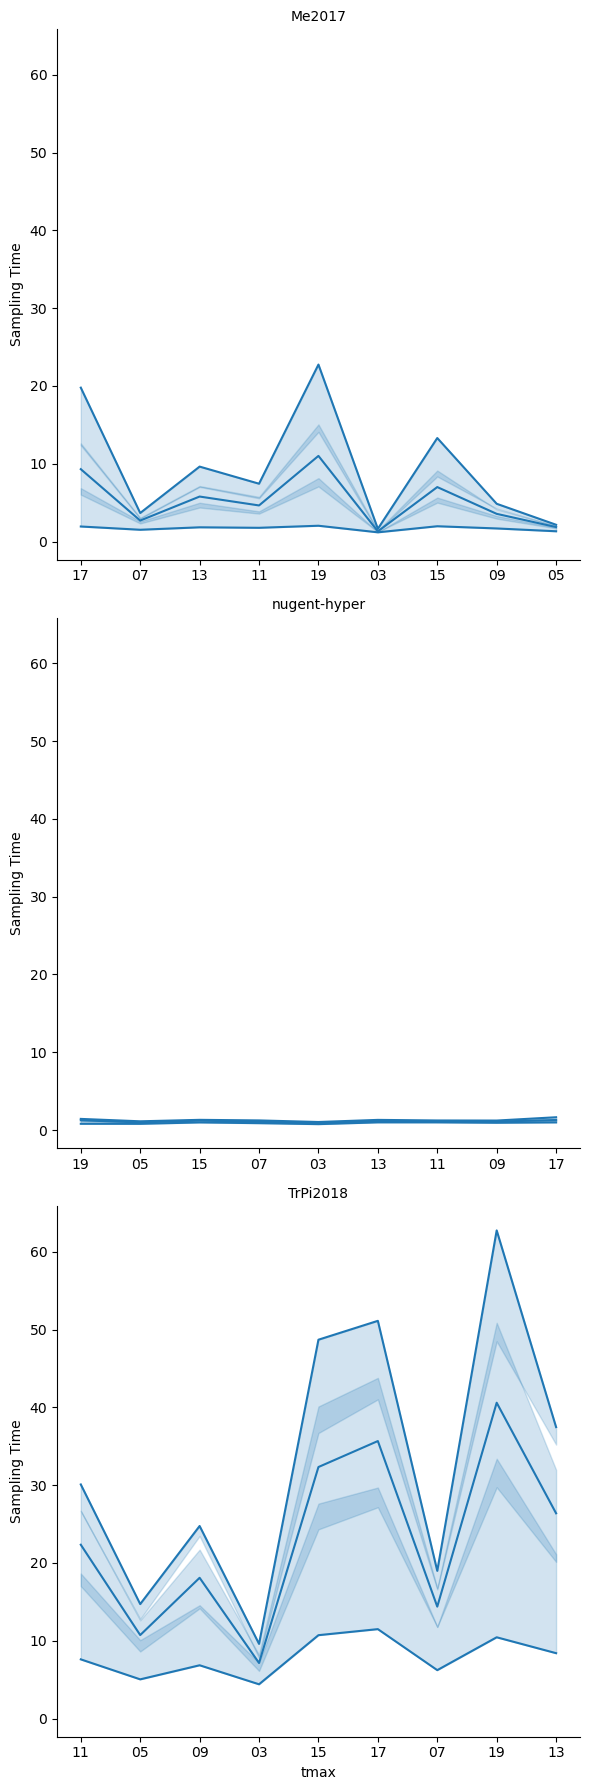

,fit_model,tmax,mean,std,min,max
0,Me2017,03,1.310824,0.155359,1.185783,1.637659
1,Me2017,05,1.861607,0.269928,1.321604,2.156669
2,Me2017,07,2.697978,0.628030,1.514701,3.668280
3,Me2017,09,3.560346,0.962181,1.683686,4.856524
4,Me2017,11,4.640679,1.649940,1.766795,7.435712
5,Me2017,13,5.784627,2.310543,1.830276,9.634737
6,Me2017,15,7.002870,3.279209,1.967540,13.309182
7,Me2017,17,9.305430,5.349147,1.934742,19.785236
8,Me2017,19,11.010600,6.419304,2.031655,22.753752
9,TrPi2018,03,7.138722,1.640029,4.399556,9.595267


In [30]:
statistics = df.groupby(['fit_model', 'tmax'])['sampling_time_minutes'].agg(['mean', 'std', 'min', 'max']).reset_index()


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting using Seaborn with smaller vertical height
g = sns.FacetGrid(df, col='fit_model', col_wrap=1, sharex=False, height=6)
g.map(sns.lineplot, 'tmax', 'sampling_time_minutes', estimator='mean', label='Average')
g.map(sns.lineplot, 'tmax', 'sampling_time_minutes', estimator='min', label='Minimum')
g.map(sns.lineplot, 'tmax', 'sampling_time_minutes', estimator='max', label='Maximum')

# Set plot labels and legend
g.set_axis_labels('tmax', 'Sampling Time')
g.set_titles(col_template="{col_name}")


# Show the plot
plt.show()

display(statistics)

In [31]:
df['sampling_time_minutes'].sum() / 60 ##hour count

39.73412485083334